In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import csv

np.seterr(invalid="ignore");

In [36]:
filename = '/Users/todisco/Documents/Numerical_Wall_Implementation_Custom/case1/N.csv'

N = []
K = []
C = []
S = []

with open(filename, newline='', encoding='utf-8-sig') as csvfile:
    filecontent = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for i, row in enumerate(filecontent):
        if i == 0:
            lbls = row[0].split(',')[0:-1]
        else:
            N.append(row[0].split(',')[0:-1])
            K.append(row[0].split(',')[-1])

filename = '/Users/todisco/Documents/Numerical_Wall_Implementation_Custom/case1/C.csv'

with open(filename, newline='', encoding='utf-8-sig') as csvfile:
    filecontent = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for i, row in enumerate(filecontent):
        if i > 0:
            C.append(row[0].split(',')[0:-1])
            S.append(row[0].split(',')[-1])

N = np.array(N, dtype='float')
K = np.array(K, dtype='float')
C = np.array(C, dtype='float')
S = np.array(S, dtype='float')

print(lbls)
print(N)
print(K)
print(C)
print(S)

['A', 'B', 'C', 'D']
[[-2.  1.  1.  0.]
 [-1.  0.  0.  1.]]
[ 1. 10.]
[[1. 0. 2. 1.]
 [0. 1. 1. 0.]]
[5. 2.]


In [83]:
N = np.array([[-2, -1, 1, 0],[-1, 0, 0, 1]])
K = np.array([1, 10])
S = np.array([5, 2])
C = np.array([[1, 0, 2, 1],[0, 1, 1, 0]])

--- 2.049434411752451 milliseconds ---
[[6.02567973 1.54737852 0.02567973 0.20271982 4.8538835 ]]


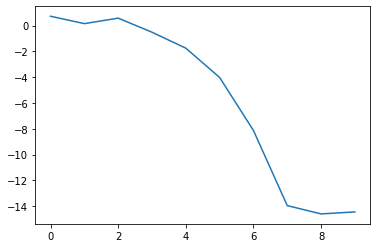

In [191]:

r = 0
start_time = time.time()
for j in range(1000):
    x = np.ones((1,np.shape(N)[1]))
    delta = []

    for i in range(10):
        Cx = C*x
        W = Cx/np.sum(Cx, axis=1)[:,None]
        W_ = np.prod((W/C)**W, axis=1)*S

        X = np.vstack((N, W))
        A = np.log(x.T)
        Y = np.log(np.hstack((K, W_)))

        x = (x*r+np.exp(np.dot(np.linalg.pinv(X), Y)))/(r+1)
        delta.append(np.linalg.norm(np.dot(X, A)-Y[:,None]))

plt.plot(np.log10(delta))
print("--- %s milliseconds ---" % ((time.time() - start_time)/j*1000))
print(x)

[[0.40360728 1.71984005 0.28015995 4.03607282]]
--- 1.2667286503422368 milliseconds ---


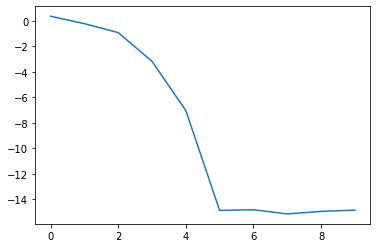

In [85]:

r = 0
start_time = time.time()
for j in range(1000):
    x = np.ones((1,np.shape(N)[1]))
    delta = []

    for i in range(10):
        x_, delta_ = solver(N, K, C, S, x)
        x = (x*r+x_)/(r+1)
        delta.append(delta_)

print(x)
plt.plot(np.log10(delta))
print("--- %s milliseconds ---" % ((time.time() - start_time)/j*1000))

In [16]:
def solver(N, K, C, S, x):
        """
        equpy implementation of Wall algorithm
        - x: the float to be rounded
        - precision (integer): the number of significant figures
        """

        Cx = C*x
        W = Cx/np.sum(Cx, axis=1)[:,None]
        W_ = np.prod((W/C)**W, axis=1)*S

        X = np.vstack((N, W))
        A = np.log(x.T)
        Y = np.log(np.hstack((K, W_)))

        x = (x*r+np.exp(np.dot(np.linalg.pinv(X), Y)))/(r+1)
        delta = np.linalg.norm(np.dot(X, A)-Y[:,None])

        return x, delta

In [152]:
def define_species_set(eq):
    """
    Extract species involved in the reaction from symbolic equations
    Parameters:
    - eq: list of equations in symbolic form
    """
    e_ = " ".join(eq)
    e_ = e_.split(" ")

    species_set = []

    for l in e_:
        if l != '+' and l != "=":
            species_set.append(l)

    for i, entry in enumerate(species_set):
        if entry[0].isdigit():
            entry_split = re.findall('\d+|\D+', entry)
            species_set[i] = "".join(entry_split[1:])

    return set(species_set)

In [4]:
def define_reactions(eq):
    """
    Converts symbolic equations defining chemical reactions to matrix form suitable for the solver
    Parameters:
    - eq: list of equations in symbolic form
    """
      
    species_set = define_species_set(eq)
    n = len(species_set)
    species = {string: index for index, string in enumerate(sorted(species_set))}

    N = np.zeros((len(eq), n))

    for i, eq_ in enumerate(eq):
        eq_ = eq_.split('=')
        eq_left = eq_[0].split('+')

        for element in eq_left:
            element = element.strip()
            element_ = re.findall('\d+|\D+', element) #obtain blocks for every species

            if len(element_) == 1:
                N[i,species[element_[0]]] = -1
            elif len(element_) > 1 and element_[0].isalpha():
                N[i,species["".join(element_)]] = -1
            else:
                N[i,species["".join(element_[1:])]] = -int(element_[0])

        eq_right = eq_[1].split('+')
        for element in eq_right:
            element = element.strip()
            element_ = re.findall('\d+|\D+', element) #obtain blocks for every species

            if len(element_) == 1:
                N[i,species[element_[0]]] = 1
            elif len(element_) > 1 and element_[0].isalpha():
                N[i,species["".join(element_)]] = 1
            else:
                N[i,species["".join(element_[1:])]] = element_[0]

    return N, n, species

In [164]:
def define_conservations(eq, n, species):
    """
    Converts symbolic equations defining mass conservations to matrix form suitable for the solver
    Parameters:
    - eq: list of equations in symbolic form
    - n: number of reactions
    - species: dictionary containing {name: index} of the species involved in the reactions
    """

    pattern = r'(\d*\.?\d*)?([A-Za-z\d]+)'
    M = np.zeros((len(eq), n))
    eq = [eq_.replace("*", "") for eq_ in eq]

    for i, eq_ in enumerate(eq):
        eq_ = eq_.split('+')

        for element_ in eq_:
            element_ = re.findall(pattern, element_)
            element_ = [elem for elem in element_[0]]
            if len(element_[0]) == 0:
                 M[i,species[element_[1]]] = 1
            else:
                M[i,species[element_[1]]] = element_[0]

    return M

In [131]:
pattern = r'(\d*\.?\d+)([A-Za-z\d]*)'
pattern = r'(\d*\.?\d*)?([A-Za-z\d]+)'
test = re.findall(pattern, 'A')
test = [t for t in test[0]]
len(test[0]) == 0

True

In [169]:
reactions = ['A + 2B = AB2',
    'AB2 + C = AB2C']

K = [100, 10]

reactions = ['2A + 2B = 2AB',
    '2AB + C = D']

mass_conservation = ['A + AB + 0.5D',
                'B + AB + 0.5D']

S = [10, 4]

N, C, species = eq_system_builder(reactions, mass_conservation)

print(N)

print(C)


[[-2.  2. -2.  0.  0.]
 [ 0. -2.  0. -1.  1.]]
[[1.  1.  0.  0.  0.5]
 [0.  1.  1.  0.  0.5]]


In [180]:
from math import floor, log10

def sig_figs(x: float, precision: int):
    """
    Code by Matt Gosden to round a float variable to number of significant figures
    - x: the float to be rounded
    - precision (integer): the number of significant figures
    """
    x = float(x)
    precision = int(precision)

    return round(x, -int(floor(log10(abs(x)))) + (precision - 1))

In [179]:
import re

def eq_system_builder(eq, mass_conservation):
      """
      Converts symbolic equations defining chemical reactions and mass conservations to matrix form suitable for the solver
      Parameters:
      - eq: list of reactions in symbolic form
      - mass_conservation: list of mass conservations in symbolic form
      """
            
      N, n, species = define_reactions(eq)
      C = define_conservations(mass_conservation, n, species)

      return N, C, species

In [170]:
reactions = ['A + 2B = AB2',
    'AB2 + C = AB2C']

K = [100, 10]

reactions = ['2A + 2B = 2AB',
    '2AB + C = D']

mass_conservation = ['A + AB + 0.5D',
                'B + AB + 0.5D']

S = [10, 4]

N, C, species = eq_system_builder(reactions, mass_conservation)


--- 4.686805937025283 milliseconds ---
[[6.02567973 1.54737852 0.02567973 0.20271982 4.8538835 ]]


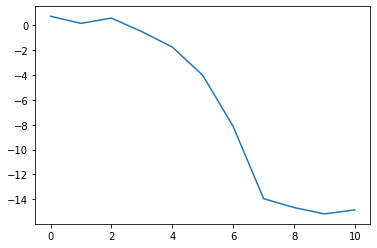

In [192]:

r = 0
start_time = time.time()
for j in range(10):
    x = np.ones((1,np.shape(N)[1]))
    delta = []

    x, delta_ = solver(N, K, C, S, np.ones((1,np.shape(N)[1])))
    delta.append(delta_)

    for i in range(10):
        x, delta_ = solver(N, K, C, S, x)
        delta.append(delta_)

plt.plot(np.log10(delta))
print("--- %s milliseconds ---" % ((time.time() - start_time)/j*1000))
print(x)

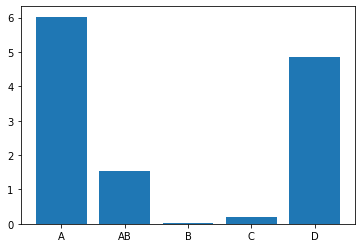

In [171]:
plt.bar(np.arange(0, len(x[0])), x[0])
plt.xticks(np.arange(0, len(x[0])), sorted(species, key=lambda x: species[x]));

In [190]:
class ChemicalReaction:
    def __init__(self, species, stoichiometry, eq_constants, mass_conservation, initial_masses):
        self.species = species
        self.N = stoichiometry
        self.eq_constants = eq_constants
        self.mass_conservation = mass_conservation
        self.initial_masses = initial_masses

    def testfun(self):
        return self.species

reaction = ChemicalReaction(species, N, K, C, S)
reaction.eq_constants = [200,10]
reaction.N

#reaction.testfun()

array([[-2.,  2., -2.,  0.,  0.],
       [ 0., -2.,  0., -1.,  1.]])